<a href="https://colab.research.google.com/github/MostafaMahdiYousef/battery-state-estimation/blob/main/SOC_FNN_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import tensorflow as tf
import scipy.io as sio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#==================================================
# 1) LOAD DATA FROM .MAT
#==================================================
file_path = '/content/drive/MyDrive/SOC_DL_Python_Dtata.mat'
mat_data = sio.loadmat(file_path)
V = mat_data['V'].squeeze()       # Nx1 -> (N,)
I = mat_data['I'].squeeze()       # Nx1 -> (N,)
T = mat_data['T'].squeeze()       # Nx1 -> (N,)
SOC = mat_data['rawSOC'].squeeze() # Nx1 -> (N,)

#==================================================
# 2) APPLY MOVING AVERAGE FILTERING
#    (As suggested in the video to smooth input signals)
#==================================================
def moving_average(signal, window_size=500):
    return np.convolve(signal, np.ones(window_size)/window_size, mode='same')

V = moving_average(V)
I = moving_average(I)
T = moving_average(T)

#==================================================
# 3) PREPARE INPUT FEATURES & TARGET
#    X shape: (N, 3),  Y shape: (N,)
#==================================================
X = np.column_stack((V, I, T))  # shape (N,3)
Y = SOC                         # shape (N,)

#==================================================
# 4) SPLIT INTO TRAIN/TEST
#==================================================
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

#==================================================
# 5) NORMALIZE THE INPUTS
#==================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

#==================================================
# 6) DEFINE A REFINED FEEDFORWARD NEURAL NETWORK
#    - Adjusted neuron count based on video suggestions
#    - Changed activation functions (tanh, leaky ReLU, clipped ReLU)
#==================================================
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(3,)),  # 3 features
    tf.keras.layers.Dense(55, activation='tanh'),  # Hidden Layer 1 (tuned neuron count)
    tf.keras.layers.Dense(82, activation=tf.keras.layers.LeakyReLU(alpha=0.03)),  # Hidden Layer 2
    tf.keras.layers.Dense(99, activation=tf.keras.layers.ReLU(max_value=1)),  # Hidden Layer 3 (Clipped ReLU)
    tf.keras.layers.Dense(1)  # Output Layer for SOC regression
])

#==================================================
# 7) COMPILE THE MODEL
#==================================================
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mean_squared_error',
    metrics=['mean_squared_error']
)

#==================================================
# 8) TRAIN THE MODEL WITH EARLY STOPPING
#==================================================
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',      # Monitor validation loss
    patience=20,             # Stop if no improvement for 20 epochs
    restore_best_weights=True # Restore best model weights
)

history = model.fit(
    X_train_scaled, Y_train,
    validation_split=0.2,       # 20% of training used for validation
    epochs=500,
    batch_size=128,
    verbose=1,
    callbacks=[early_stopping]  # Add early stopping callback
)

#==================================================
# 9) EVALUATE ON TEST SET
#==================================================
test_loss, test_mse = model.evaluate(X_test_scaled, Y_test, verbose=0)
print(f"Test MSE: {test_mse:.4f}")

# Optional: compute RMSE
import math
test_rmse = math.sqrt(test_mse)
print(f"Test RMSE: {test_rmse:.4f}")


Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.4017 - mean_squared_error: 0.4017 - val_loss: 0.0377 - val_mean_squared_error: 0.0377
Epoch 2/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0361 - mean_squared_error: 0.0361 - val_loss: 0.0528 - val_mean_squared_error: 0.0528
Epoch 3/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0421 - mean_squared_error: 0.0421 - val_loss: 0.0153 - val_mean_squared_error: 0.0153
Epoch 4/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0191 - val_mean_squared_error: 0.0191
Epoch 5/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0162 - mean_squared_error: 0.0162 - val_loss: 0.0100 - val_mean_squared_error: 0.0100
Epoch 6/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 0.0101 - val_mean_squared_error: 0.0101
Epoch 7/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0071 - val_mean_

In [ ]:
X_train.shape

(1096, 3)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


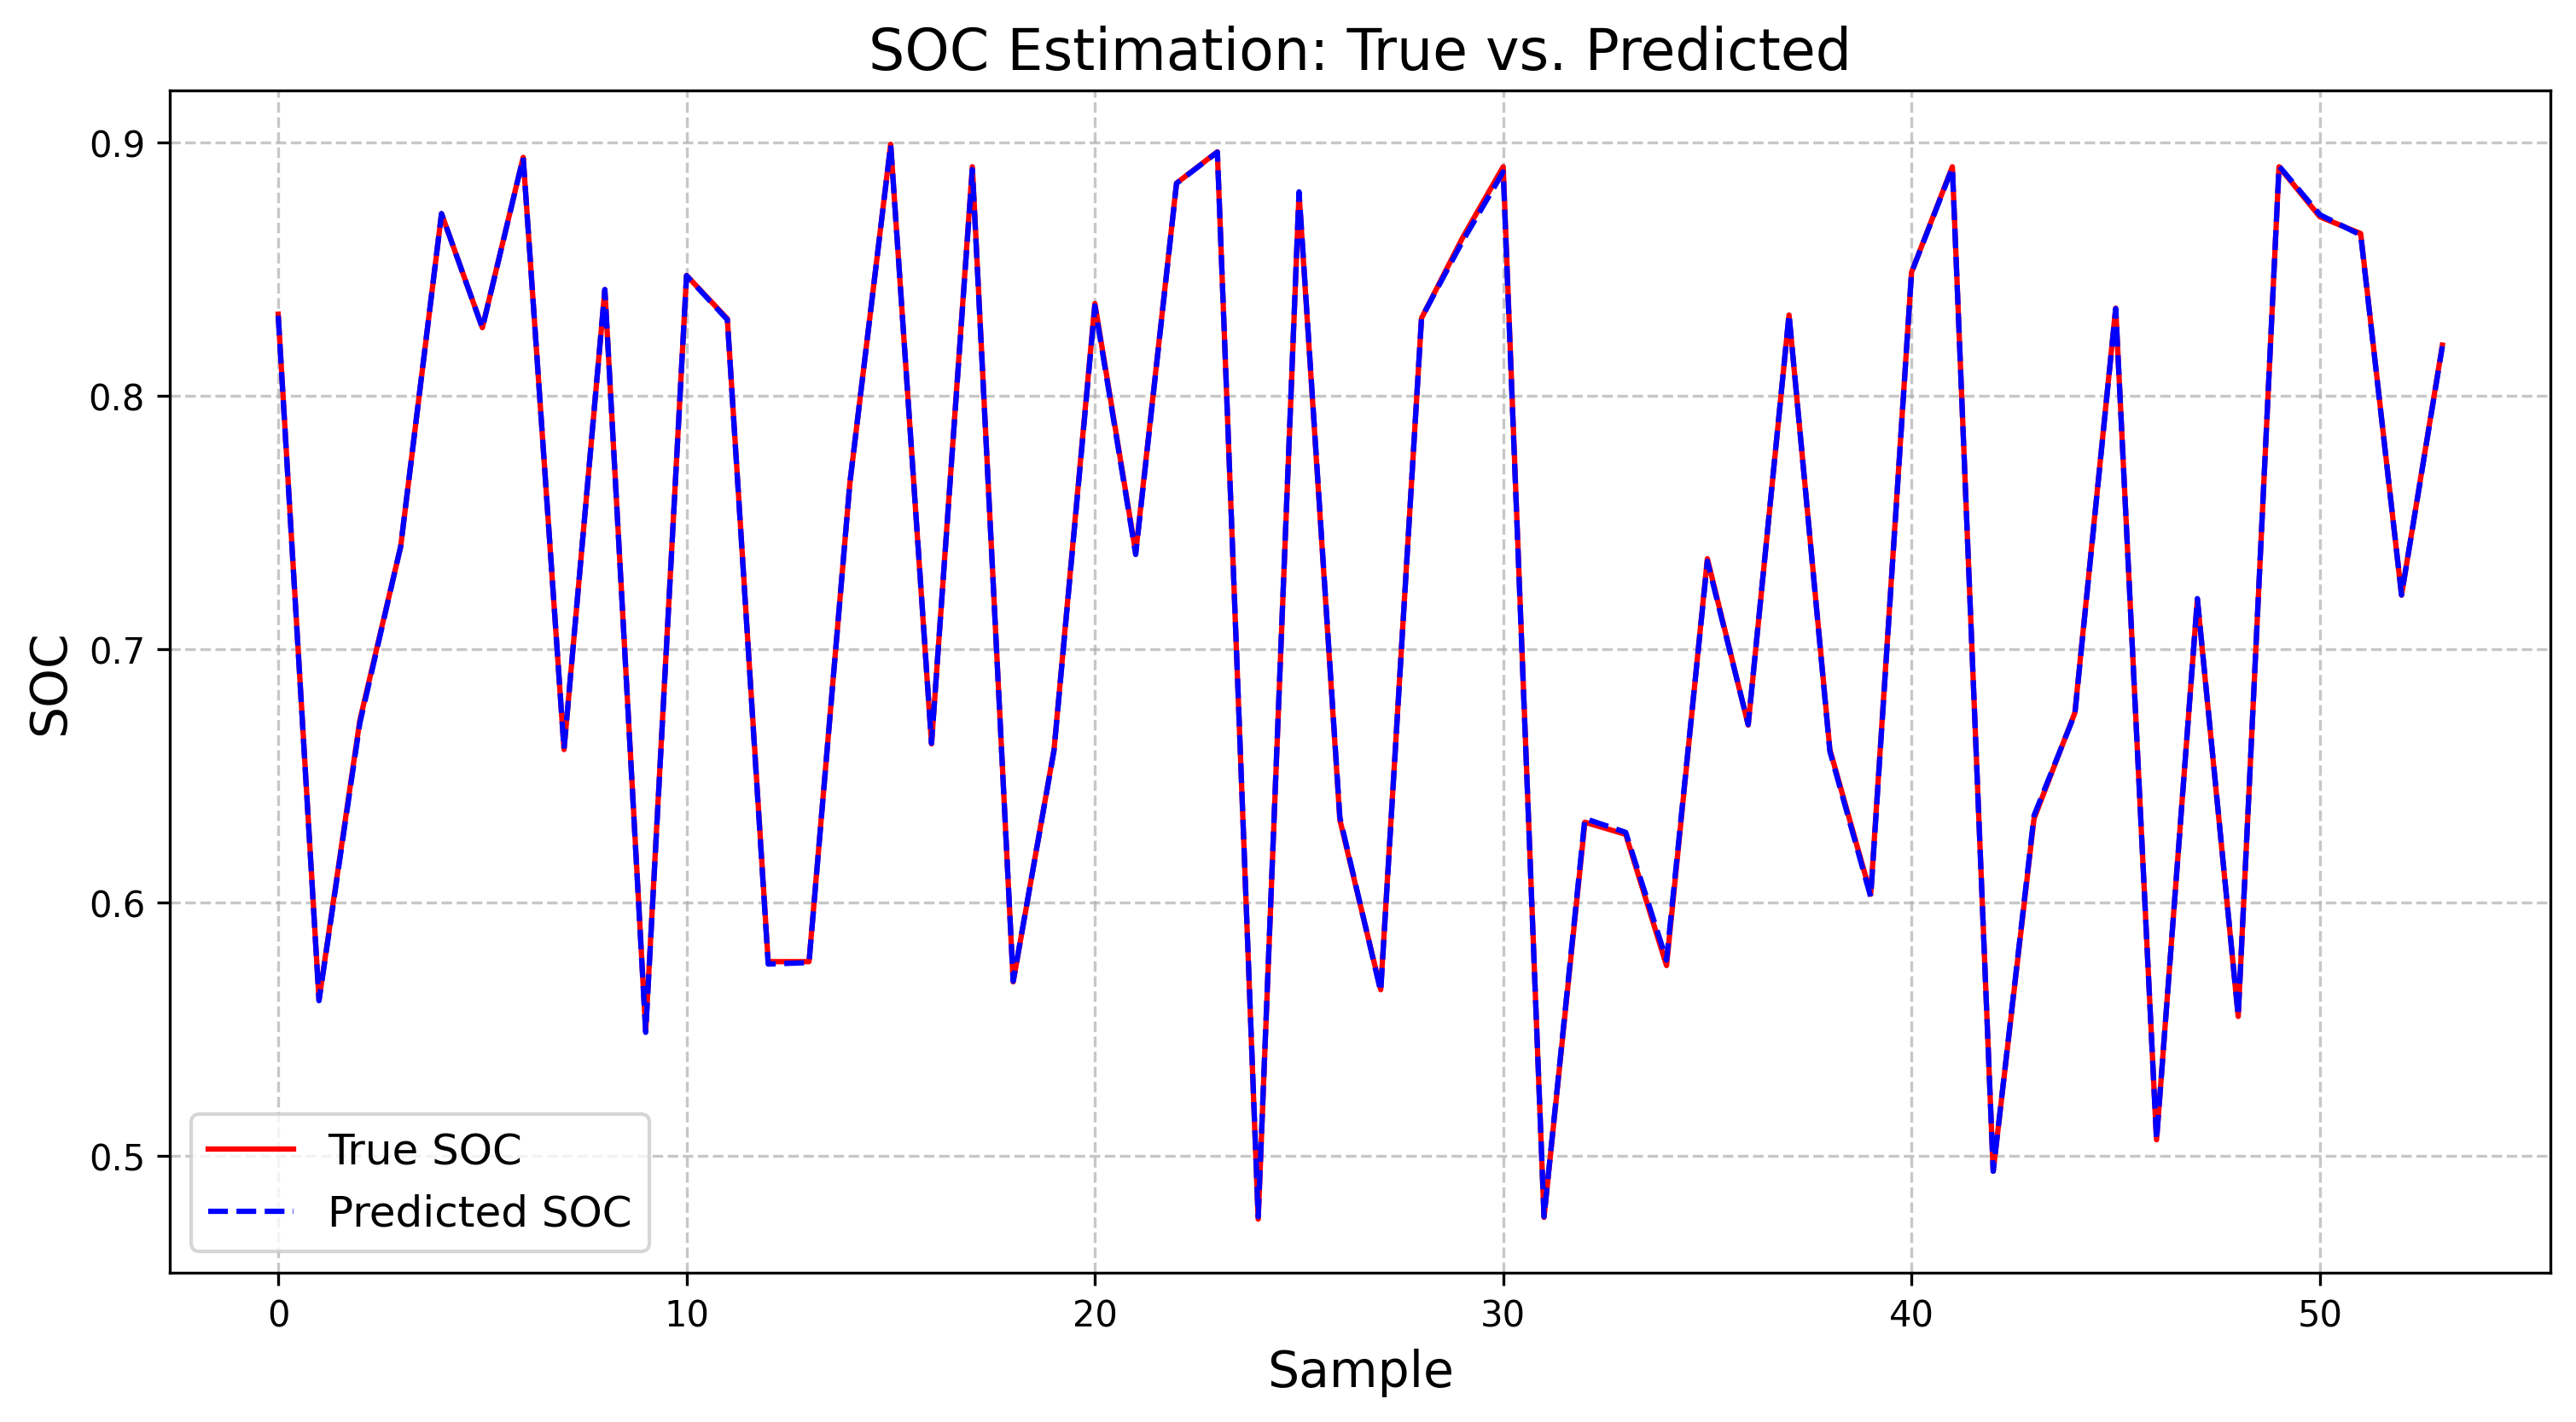

In [ ]:
import matplotlib.pyplot as plt

# Generate predictions using the trained model
Y_pred = model.predict(X_test_scaled)
Y_pred = Y_pred.squeeze()  # Convert from (N,1) to (N,)

# Increase figure size and resolution
plt.figure(figsize=(12, 6), dpi=300)  # Adjust DPI for better resolution

# Plot the first 20% of test data
plt.plot(Y_test[:int(Y_test.shape[0] * 0.2)], 'r', label='True SOC', linewidth=1.5)
plt.plot(Y_pred[:int(Y_pred.shape[0] * 0.2)], 'b--', label='Predicted SOC', linewidth=1.5)

# Labels and title
plt.xlabel("Sample", fontsize=14)
plt.ylabel("SOC", fontsize=14)
plt.title("SOC Estimation: True vs. Predicted", fontsize=16)

# Legend and grid
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)

# Show plot
plt.show()



In [ ]:

# e.g. mat_data['Voltage'] is Nx1, etc.
# V = mat_data['V'].squeeze()       # Nx1 -> (N,)
# I = mat_data['I'].squeeze()       # Nx1 -> (N,)
# T = mat_data['T'].squeeze()   # Nx1 -> (N,)
# SOC = mat_data['rawSOC'].squeeze()         # Nx1 -> (N,)
V = mat_data['V']      # Nx1 -> (N,)
print(V.shape)
V = mat_data['V'].squeeze()     # Nx1 -> (N,)
print(V.shape)
# print(mat_data)
X = np.column_stack((V, I, T))  # shape (N,3)
print(X.shape)
print(X)

(1370, 1)
(1370,)
(1370, 3)
[[  4.42105144  17.69687536 165.2603407 ]
 [  4.46240623  17.67475041 165.92299774]
 [  4.42937381  17.65268504 166.58537101]
 ...
 [  3.6536236  -16.31390364 169.25554941]
 [  3.58754635 -16.29093498 168.59722676]
 [  3.569676   -16.26836659 167.9391681 ]]


In [ ]:
X = np.column_stack((V, I, T))  # shape (N,3)
Y = SOC                         # shape (N,)

#==================================================
# 3) SPLIT INTO TRAIN/TEST
#==================================================
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
mean=X_train.mean(axis=0)
std=X_train.std(axis=0)
print('Mean: ',mean)
print('STD: ',std)
print('\n\nUnscaled:\n\n',X_train)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
print('\n\nScaled:\n\n',X_train_scaled)
mean_scaled=X_train_scaled.mean(axis=0)
std_scaled=X_train_scaled.std(axis=0)
print('Mean: ',mean_scaled)
print('STD: ',std_scaled)

Mean:  [  3.66848187 -22.51622846 347.30546627]
STD:  [ 0.45667548 39.79607255 21.54311763]


Unscaled:

 [[ 4.27984067e+00  2.08799531e-01  3.32432246e+02]
 [ 3.42568410e+00 -4.70793170e+01  3.32951216e+02]
 [ 2.82578637e+00 -7.78603280e+01  3.97703926e+02]
 ...
 [ 3.08458708e+00 -5.78976398e+01  3.44953107e+02]
 [ 3.05065169e+00 -6.99019717e+01  3.68427223e+02]
 [ 3.81118503e+00 -1.13541103e+01  3.27992117e+02]]


Scaled:

 [[ 1.33871607  0.57103695 -0.69039313]
 [-0.53166369 -0.61722394 -0.66630328]
 [-1.84528301 -1.3906925   2.33942277]
 ...
 [-1.27857706 -0.88906792 -0.10919306]
 [-1.3528867  -1.19071406  0.98044103]
 [ 0.31248263  0.28048291 -0.89649743]]
Mean:  [-7.82013343e-15  2.70312969e-16  1.79936155e-14]
STD:  [1. 1. 1.]


In [ ]:
([ 4.27984067e+00 , 2.08799531e-01 , 3.32432246e+02]-mean)/std

array([ 1.33871606,  0.57103695, -0.69039312])